In [1]:
%matplotlib inline


# Model Complexity Influence

Demonstrate how model complexity influences both prediction accuracy and
computational performance.

We will be using two datasets:
    - `diabetes_dataset` for regression.
      This dataset consists of 10 measurements taken from diabetes patients.
      The task is to predict disease progression;
    - `20newsgroups_dataset` for classification. This dataset consists of
      newsgroup posts. The task is to predict on which topic (out of 20 topics)
      the post is written about.

We will model the complexity influence on three different estimators:
    - :class:`~sklearn.linear_model.SGDClassifier` (for classification data)
      which implements stochastic gradient descent learning;

    - :class:`~sklearn.svm.NuSVR` (for regression data) which implements
      Nu support vector regression;

    - :class:`~sklearn.ensemble.GradientBoostingRegressor` builds an additive
      model in a forward stage-wise fashion. Notice that
      :class:`~sklearn.ensemble.HistGradientBoostingRegressor` is much faster
      than :class:`~sklearn.ensemble.GradientBoostingRegressor` starting with
      intermediate datasets (`n_samples >= 10_000`), which is not the case for
      this example.


We make the model complexity vary through the choice of relevant model
parameters in each of our selected models. Next, we will measure the influence
on both computational performance (latency) and predictive power (MSE or
Hamming Loss).


In [2]:
# Authors: Eustache Diemert <eustache@diemert.fr>
#          Maria Telenczuk <https://github.com/maikia>
#          Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: BSD 3 clause

import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import NuSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import hamming_loss

# Initialize random generator
np.random.seed(0)

## Load the data

First we load both datasets.

<div class="alert alert-info"><h4>Note</h4><p>We are using
   :func:`~sklearn.datasets.fetch_20newsgroups_vectorized` to download 20
   newsgroups dataset. It returns ready-to-use features.</p></div>

<div class="alert alert-info"><h4>Note</h4><p>``X`` of the 20 newsgroups dataset is a sparse matrix while ``X``
   of diabetes dataset is a numpy array.</p></div>




In [3]:
def generate_data(case):
    """Generate regression/classification data."""
    if case == "regression":
        X, y = datasets.load_diabetes(return_X_y=True)
        train_size = 0.8
    elif case == "classification":
        X, y = datasets.fetch_20newsgroups_vectorized(subset="all", return_X_y=True)
        train_size = 0.4  # to make the example run faster

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=0
    )

    data = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
    return data


regression_data = generate_data("regression")
classification_data = generate_data("classification")

## Benchmark influence
Next, we can calculate the influence of the parameters on the given
estimator. In each round, we will set the estimator with the new value of
``changing_param`` and we will be collecting the prediction times, prediction
performance and complexities to see how those changes affect the estimator.
We will calculate the complexity using ``complexity_computer`` passed as a
parameter.




In [4]:
def benchmark_influence(conf):
    """
    Benchmark influence of `changing_param` on both MSE and latency.
    """
    prediction_times = []
    prediction_powers = []
    complexities = []
    for param_value in conf["changing_param_values"]:
        conf["tuned_params"][conf["changing_param"]] = param_value
        estimator = conf["estimator"](**conf["tuned_params"])

        print("Benchmarking %s" % estimator)
        estimator.fit(conf["data"]["X_train"], conf["data"]["y_train"])
        conf["postfit_hook"](estimator)
        complexity = conf["complexity_computer"](estimator)
        complexities.append(complexity)
        start_time = time.time()
        for _ in range(conf["n_samples"]):
            y_pred = estimator.predict(conf["data"]["X_test"])
        elapsed_time = (time.time() - start_time) / float(conf["n_samples"])
        prediction_times.append(elapsed_time)
        pred_score = conf["prediction_performance_computer"](
            conf["data"]["y_test"], y_pred
        )
        prediction_powers.append(pred_score)
        print(
            "Complexity: %d | %s: %.4f | Pred. Time: %fs\n"
            % (
                complexity,
                conf["prediction_performance_label"],
                pred_score,
                elapsed_time,
            )
        )
    return prediction_powers, prediction_times, complexities

## Choose parameters

We choose the parameters for each of our estimators by making
a dictionary with all the necessary values.
``changing_param`` is the name of the parameter which will vary in each
estimator.
Complexity will be defined by the ``complexity_label`` and calculated using
`complexity_computer`.
Also note that depending on the estimator type we are passing
different data.




In [5]:
def _count_nonzero_coefficients(estimator):
    a = estimator.coef_.toarray()
    return np.count_nonzero(a)


configurations = [
    {
        "estimator": SGDClassifier,
        "tuned_params": {
            "penalty": "elasticnet",
            "alpha": 0.001,
            "loss": "modified_huber",
            "fit_intercept": True,
            "tol": 1e-1,
            "n_iter_no_change": 2,
        },
        "changing_param": "l1_ratio",
        "changing_param_values": [0.25, 0.5, 0.75, 0.9],
        "complexity_label": "non_zero coefficients",
        "complexity_computer": _count_nonzero_coefficients,
        "prediction_performance_computer": hamming_loss,
        "prediction_performance_label": "Hamming Loss (Misclassification Ratio)",
        "postfit_hook": lambda x: x.sparsify(),
        "data": classification_data,
        "n_samples": 5,
    },
    {
        "estimator": NuSVR,
        "tuned_params": {"C": 1e3, "gamma": 2**-15},
        "changing_param": "nu",
        "changing_param_values": [0.05, 0.1, 0.2, 0.35, 0.5],
        "complexity_label": "n_support_vectors",
        "complexity_computer": lambda x: len(x.support_vectors_),
        "data": regression_data,
        "postfit_hook": lambda x: x,
        "prediction_performance_computer": mean_squared_error,
        "prediction_performance_label": "MSE",
        "n_samples": 15,
    },
    {
        "estimator": GradientBoostingRegressor,
        "tuned_params": {
            "loss": "squared_error",
            "learning_rate": 0.05,
            "max_depth": 2,
        },
        "changing_param": "n_estimators",
        "changing_param_values": [10, 25, 50, 75, 100],
        "complexity_label": "n_trees",
        "complexity_computer": lambda x: x.n_estimators,
        "data": regression_data,
        "postfit_hook": lambda x: x,
        "prediction_performance_computer": mean_squared_error,
        "prediction_performance_label": "MSE",
        "n_samples": 15,
    },
]

## Run the code and plot the results

We defined all the functions required to run our benchmark. Now, we will loop
over the different configurations that we defined previously. Subsequently,
we can analyze the plots obtained from the benchmark:
Relaxing the `L1` penalty in the SGD classifier reduces the prediction error
but leads to an increase in the training time.
We can draw a similar analysis regarding the training time which increases
with the number of support vectors with a Nu-SVR. However, we observed that
there is an optimal number of support vectors which reduces the prediction
error. Indeed, too few support vectors lead to an under-fitted model while
too many support vectors lead to an over-fitted model.
The exact same conclusion can be drawn for the gradient-boosting model. The
only the difference with the Nu-SVR is that having too many trees in the
ensemble is not as detrimental.




Benchmarking SGDClassifier(alpha=0.001, l1_ratio=0.25, loss='modified_huber',
              n_iter_no_change=2, penalty='elasticnet', tol=0.1)
Complexity: 4948 | Hamming Loss (Misclassification Ratio): 0.2675 | Pred. Time: 0.081027s

Benchmarking SGDClassifier(alpha=0.001, l1_ratio=0.5, loss='modified_huber',
              n_iter_no_change=2, penalty='elasticnet', tol=0.1)
Complexity: 1847 | Hamming Loss (Misclassification Ratio): 0.3264 | Pred. Time: 0.063025s

Benchmarking SGDClassifier(alpha=0.001, l1_ratio=0.75, loss='modified_huber',
              n_iter_no_change=2, penalty='elasticnet', tol=0.1)
Complexity: 997 | Hamming Loss (Misclassification Ratio): 0.3383 | Pred. Time: 0.047581s

Benchmarking SGDClassifier(alpha=0.001, l1_ratio=0.9, loss='modified_huber',
              n_iter_no_change=2, penalty='elasticnet', tol=0.1)
Complexity: 802 | Hamming Loss (Misclassification Ratio): 0.3582 | Pred. Time: 0.043763s

Benchmarking NuSVR(C=1000.0, gamma=3.0517578125e-05, nu=0.05)
Comple

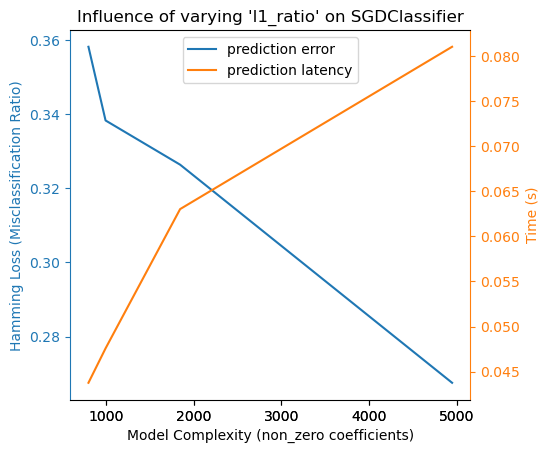

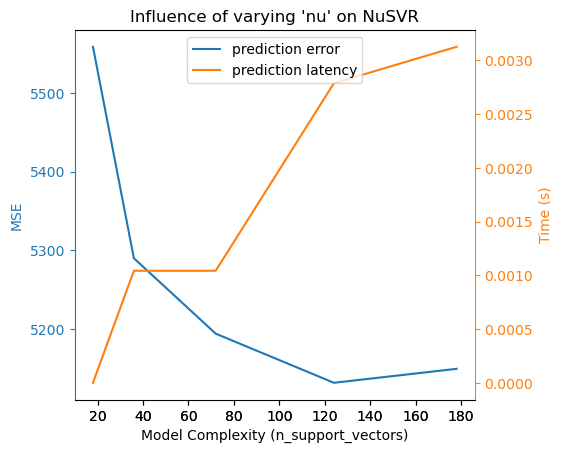

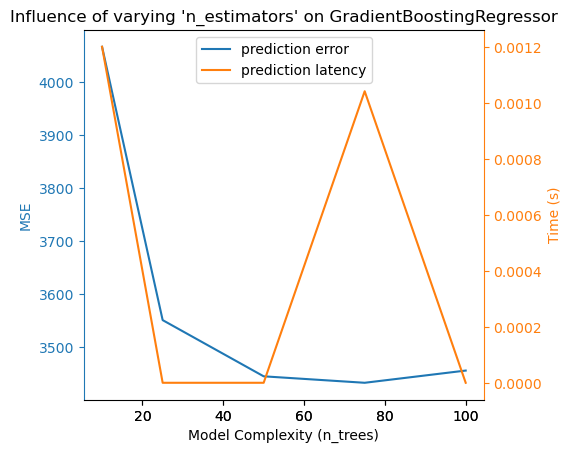

In [6]:
def plot_influence(conf, mse_values, prediction_times, complexities):
    """
    Plot influence of model complexity on both accuracy and latency.
    """

    fig = plt.figure()
    fig.subplots_adjust(right=0.75)

    # first axes (prediction error)
    ax1 = fig.add_subplot(111)
    line1 = ax1.plot(complexities, mse_values, c="tab:blue", ls="-")[0]
    ax1.set_xlabel("Model Complexity (%s)" % conf["complexity_label"])
    y1_label = conf["prediction_performance_label"]
    ax1.set_ylabel(y1_label)

    ax1.spines["left"].set_color(line1.get_color())
    ax1.yaxis.label.set_color(line1.get_color())
    ax1.tick_params(axis="y", colors=line1.get_color())

    # second axes (latency)
    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
    line2 = ax2.plot(complexities, prediction_times, c="tab:orange", ls="-")[0]
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    y2_label = "Time (s)"
    ax2.set_ylabel(y2_label)
    ax1.spines["right"].set_color(line2.get_color())
    ax2.yaxis.label.set_color(line2.get_color())
    ax2.tick_params(axis="y", colors=line2.get_color())

    plt.legend(
        (line1, line2), ("prediction error", "prediction latency"), loc="upper center"
    )

    plt.title(
        "Influence of varying '%s' on %s"
        % (conf["changing_param"], conf["estimator"].__name__)
    )


for conf in configurations:
    prediction_performances, prediction_times, complexities = benchmark_influence(conf)
    plot_influence(conf, prediction_performances, prediction_times, complexities)
plt.show()

## Conclusion

As a conclusion, we can deduce the following insights:

* a model which is more complex (or expressive) will require a larger
  training time;
* a more complex model does not guarantee to reduce the prediction error.

These aspects are related to model generalization and avoiding model
under-fitting or over-fitting.

